In [1]:
import glob, scipy
import cv2, imageio
import numpy as np

from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
image_paths = glob.glob('retina2/*.bmp')
images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]

H, W = images[0].shape
print(f'Image shape: height={H}, width={W}')

FILENAME_OFFSET = int(image_paths[0][-7:-4])
print(f'Filename offset: {FILENAME_OFFSET}')

Image shape: height=349, width=350
Filename offset: 172


In [3]:
## Uncomment this block to generate a GIF of the original images

# with imageio.get_writer('viz_outputs/retina2_original.gif', mode='I', fps=30) as writer:
#     for i, image in enumerate(images):
#         image_copy = image.copy()
#         cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
#         cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
#         writer.append_data(image)

### Median filtering

We see the effect of median filtering on the noise and smoothing of the image

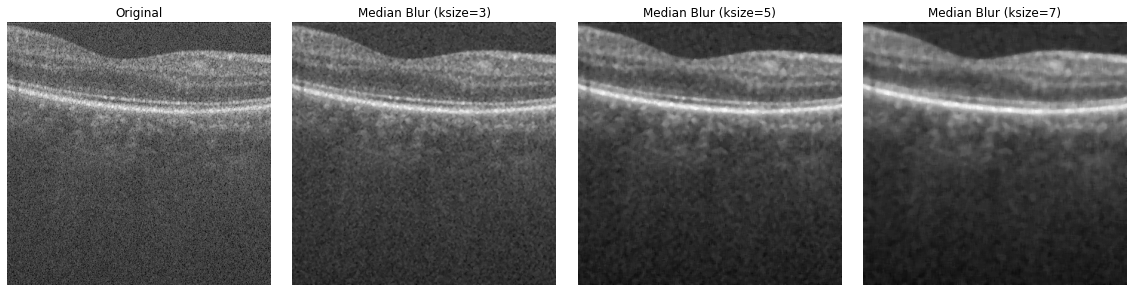

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), facecolor='white')

ax[0].imshow(images[0], cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

for i in range(1, 4):
    ax[i].imshow(cv2.medianBlur(images[0], 2*i+1), cmap='gray')
    ax[i].set_title(f'Median Blur (ksize={2*i+1})')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

### Temporal averaging experiment

Use a window size of 30 for initial results

In [5]:
tavg_images = []
minmax_shifts = []
OFFSET, Nwindow = 0, 30

for KSIZE in tqdm([1, 3, 5]):

    first_image = scipy.ndimage.shift(images[OFFSET], (0, 0))
    first_image = cv2.medianBlur(first_image, KSIZE)
    corrected_images = [first_image]

    shift_lr_pos, shift_lr_neg = 0, 0
    shift_ud_pos, shift_ud_neg = 0, 0

    for i in range(OFFSET+1, OFFSET+Nwindow):
        offset_image = cv2.medianBlur(images[i], KSIZE)
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1000)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)

        if shift[1] > 0:
            shift_lr_pos = max(shift_lr_pos, shift[1])
        else:
            shift_lr_neg =  min(shift_lr_neg, shift[1])

        if shift[0] > 0:
            shift_ud_pos = max(shift_ud_pos, shift[0])
        else:
            shift_ud_neg = min(shift_ud_neg, shift[0])

    minmax_shifts.append((shift_lr_pos, shift_lr_neg, shift_ud_pos, shift_ud_neg))

    # with imageio.get_writer('viz_outputs/retina2_shifted.gif', mode='I', fps=10) as writer:
    #     for i, image in enumerate(corrected_images):
    #         image_copy = image.copy()
    #         cv2.putText(image_copy, f'Image {FILENAME_OFFSET+OFFSET+i}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
    #         cv2.putText(image_copy, f'Image {FILENAME_OFFSET+OFFSET+i}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    #         writer.append_data(image_copy)

    tavg_images.append(np.mean(corrected_images, axis=0))

100%|██████████| 3/3 [00:21<00:00,  7.33s/it]


We see the effect that median filtering before temporal averaging has. Noise is reduced but edges are slightly blurred.

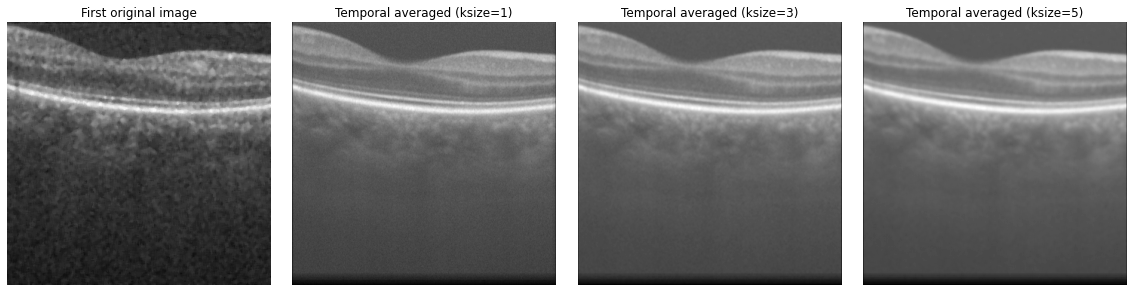

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), facecolor='white')
ax[0].imshow(first_image, cmap='gray')
ax[0].set_title('First original image')
ax[0].axis('off')

for i in range(3):
    filename = f'viz_outputs/retina2_ksize{2*i+1}_tavg{Nwindow}_{FILENAME_OFFSET+OFFSET}-{Nwindow+FILENAME_OFFSET+OFFSET-1}'
    cv2.imwrite(filename+'.bmp', tavg_images[i].astype(np.uint8))
    np.save(filename+'.npy', tavg_images[i])
    ax[i+1].imshow(tavg_images[i], cmap='gray')
    ax[i+1].set_title(f'Temporal averaged (ksize={2*i+1})')
    ax[i+1].axis('off')

plt.tight_layout()
plt.show()

Use auto canny function, median filter with `ksize=1,3,5` are used for final edge image.

In [7]:
def auto_canny(image, sigma=0.33):
	image = image.astype(np.uint8)
	H, W = image.shape[:2]
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

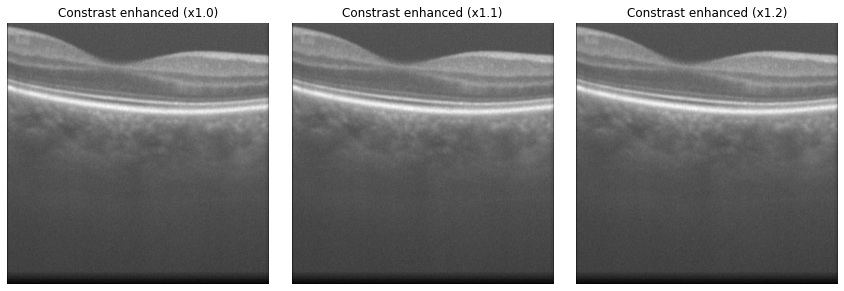

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), facecolor='white')

for i in range(3):
    tavg = tavg_images[0]
    ax[i].imshow(np.clip(tavg*float(f'1.{i}'), 0, 255), cmap='gray')
    ax[i].set_title(f'Constrast enhanced (x1.{i})')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

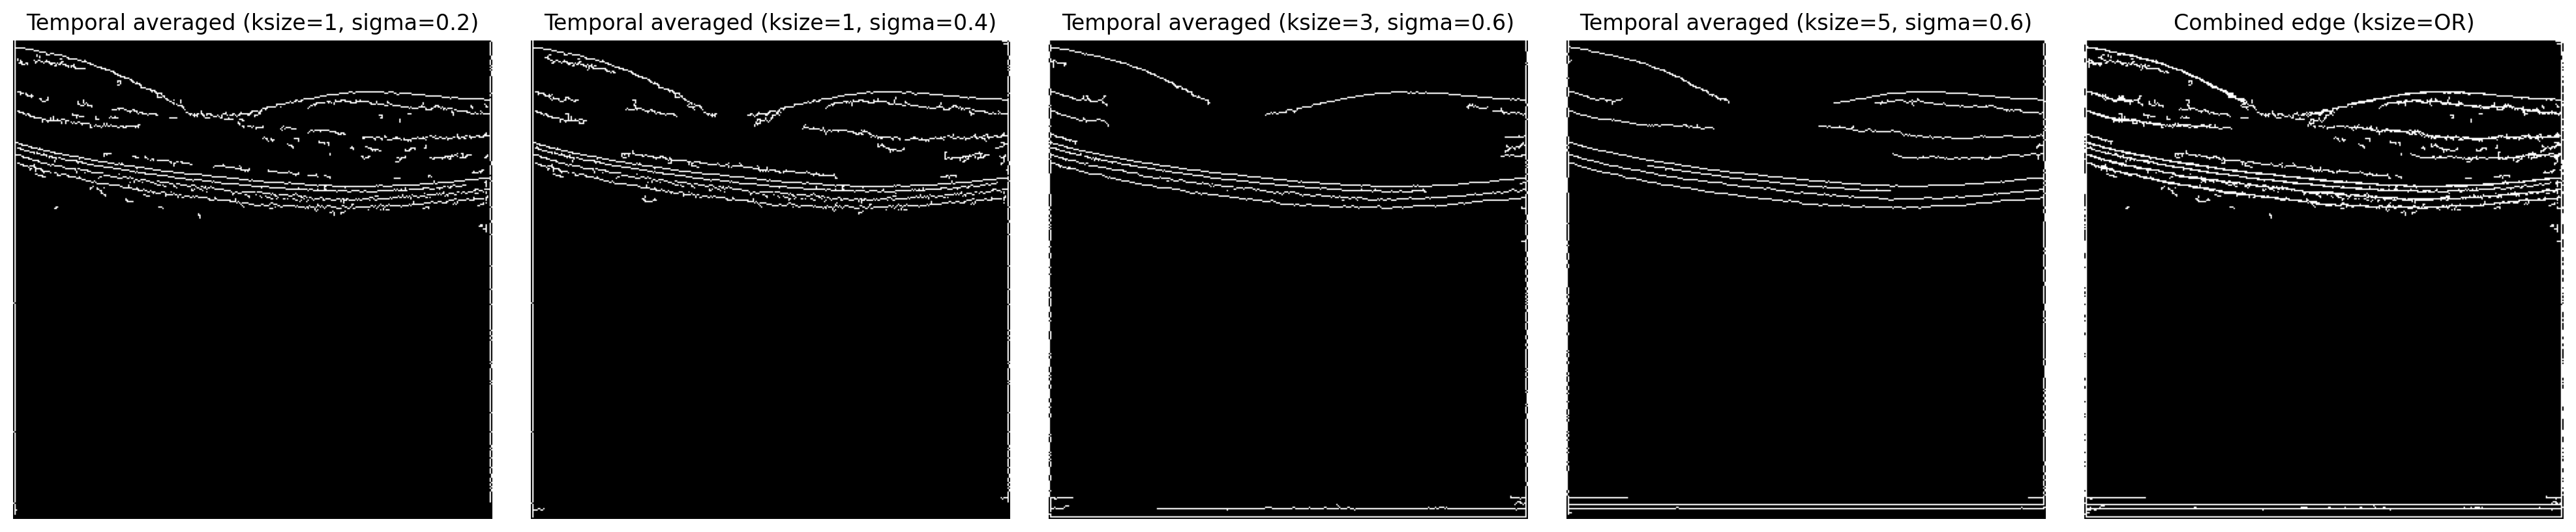

In [21]:
AUTO_CANNY_SIGMA = [0.2, 0.4, 0.6, 0.6]
tavg_edge_images = []

fig, ax = plt.subplots(1, 5, figsize=(20, 4), facecolor='white', dpi=200)

for i, j in zip(range(4), [0, 0, 1, 2]):
    tavg = tavg_images[j]
    tavg = np.clip(tavg, 0, 255)
    tavg = auto_canny(tavg, AUTO_CANNY_SIGMA[i])
    tavg_edge_images.append(tavg)
    ax[i].imshow(tavg, cmap='gray')
    ax[i].set_title(f'Temporal averaged (ksize={2*j+1}, sigma={AUTO_CANNY_SIGMA[i]})')
    ax[i].axis('off')

edge = np.clip(np.sum(tavg_edge_images, axis=0), 0, 255).astype(np.uint8)
ax[-1].imshow(edge, cmap='gray')
ax[-1].set_title('Combined edge (ksize=OR)')
ax[-1].axis('off')

plt.tight_layout()
plt.show()

### Calculate zero masks

Set the regions affected by 2D image registration earlier to be zero since edges in those areas occur because of temporal averaging

In [9]:
# (shift_lr_pos, shift_lr_neg, shift_ud_pos, shift_ud_neg)

minmax_shifts

[(1.89, -4.067, 0.33, -15.808),
 (0.184, -0.204, 0, -15.41),
 (0.103, -0.059, 0.25, -15.938)]

In [10]:
edge_shift_lr_pos = max([shifts[0] for shifts in minmax_shifts[1:]])
edge_shift_lr_neg = min([shifts[1] for shifts in minmax_shifts[1:]])
edge_shift_ud_pos = max([shifts[2] for shifts in minmax_shifts[1:]])
edge_shift_ud_neg = min([shifts[3] for shifts in minmax_shifts[1:]])

edge_shift_lr_pos, edge_shift_lr_neg, edge_shift_ud_pos, edge_shift_ud_neg

(0.184, -0.204, 0.25, -15.938)

In [11]:
edge_shift_lr_pos = int(edge_shift_lr_pos) + 1
edge_shift_lr_neg = int(edge_shift_lr_neg) - 1
edge_shift_ud_pos = int(edge_shift_ud_pos) + 1
edge_shift_ud_neg = int(edge_shift_ud_neg) - 1

edge_shift_lr_pos = edge_shift_lr_pos if edge_shift_lr_pos > 0 else 0
edge_shift_lr_neg = edge_shift_lr_neg if edge_shift_lr_neg < 0 else -1
edge_shift_ud_pos = edge_shift_ud_pos if edge_shift_ud_pos > 0 else 0
edge_shift_ud_neg = edge_shift_ud_neg if edge_shift_ud_neg < 0 else -1

edge_shift_lr_pos, edge_shift_lr_neg, edge_shift_ud_pos, edge_shift_ud_neg

(1, -1, 1, -16)

In [12]:
edge_zero = edge.copy()

edge_zero[:edge_shift_ud_pos, :] = 0
edge_zero[edge_shift_ud_neg:, :] = 0
edge_zero[:, :edge_shift_lr_pos] = 0
edge_zero[:, edge_shift_lr_neg:] = 0

### Skeletonization

*Source: https://docs.opencv.org/4.4.0/df/d2d/group__ximgproc.html*

Adding the edge maps from various results causes some edges to be > 1 pixel thickness.  
Use skeletonization to thin out the edge image.

In [13]:
edge_skeleton1 = cv2.ximgproc.thinning(edge_zero, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

### Vertical Erosion and Horizontal Dilation

*Source: https://docs.opencv.org/3.4/dd/dd7/tutorial_morph_lines_detection.html*

Remove vertical lines since we have prior knowledge on our images

In [14]:
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))

edge_vert = cv2.erode(edge_skeleton1, verticalStructure, iterations=1)
edge_hori = cv2.dilate(edge_vert, verticalStructure, iterations=1)
edge_hori = cv2.dilate(edge_hori[:, ::-1], verticalStructure, iterations=1)[:, ::-1]
edge_skeleton2 = cv2.ximgproc.thinning(edge_hori, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

### Edge filtering and cleanup

In [15]:
# Remove edges which are too short
def remove_short_edges(edge_image, min_length=10):
    edge_image = edge_image.copy()
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        if len(contour) < min_length:
            cv2.drawContours(edge_image, [contour], 0, 0, -1)
    return edge_image


edge_final = remove_short_edges(edge_skeleton2, min_length=5)

In [16]:
# Find lowest long edge and remove all edges below it

def filter_conditional_lines(edge_image, longest_min_length=100):

    edge_image = edge_image.copy()
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Find longest edge at the bottom
    lowest_contour, lowest_y = 0, 0
    for contour in contours:
        if len(contour) > longest_min_length:
            new_y = np.min(contour[:, 0, 1])
            if new_y > lowest_y:
                lowest_contour = contour
                lowest_y = new_y

    lowest_x2y = {x: y for x, y in lowest_contour[:, 0, :]}

    # Remove edges below the longest edges
    for contour in contours:
        if np.min(contour[:, 0, 1]) > lowest_y:
            index_of_highest_y = np.argmin(contour[:, 0, 1])
            x_of_highest_y = contour[index_of_highest_y, 0, 0]
            y_of_highest_y = contour[index_of_highest_y, 0, 1]
            if lowest_x2y.get(x_of_highest_y, 0) < y_of_highest_y:
                cv2.drawContours(edge_image, [contour], 0, 0, -1)

    # Visualise the lowest point
    # cv2.line(edge_image, (0, lowest_y), (edge_image.shape[1], lowest_y), 255, 1)

    return edge_image


edge_final2 = filter_conditional_lines(edge_final, longest_min_length=100)

### Process Results

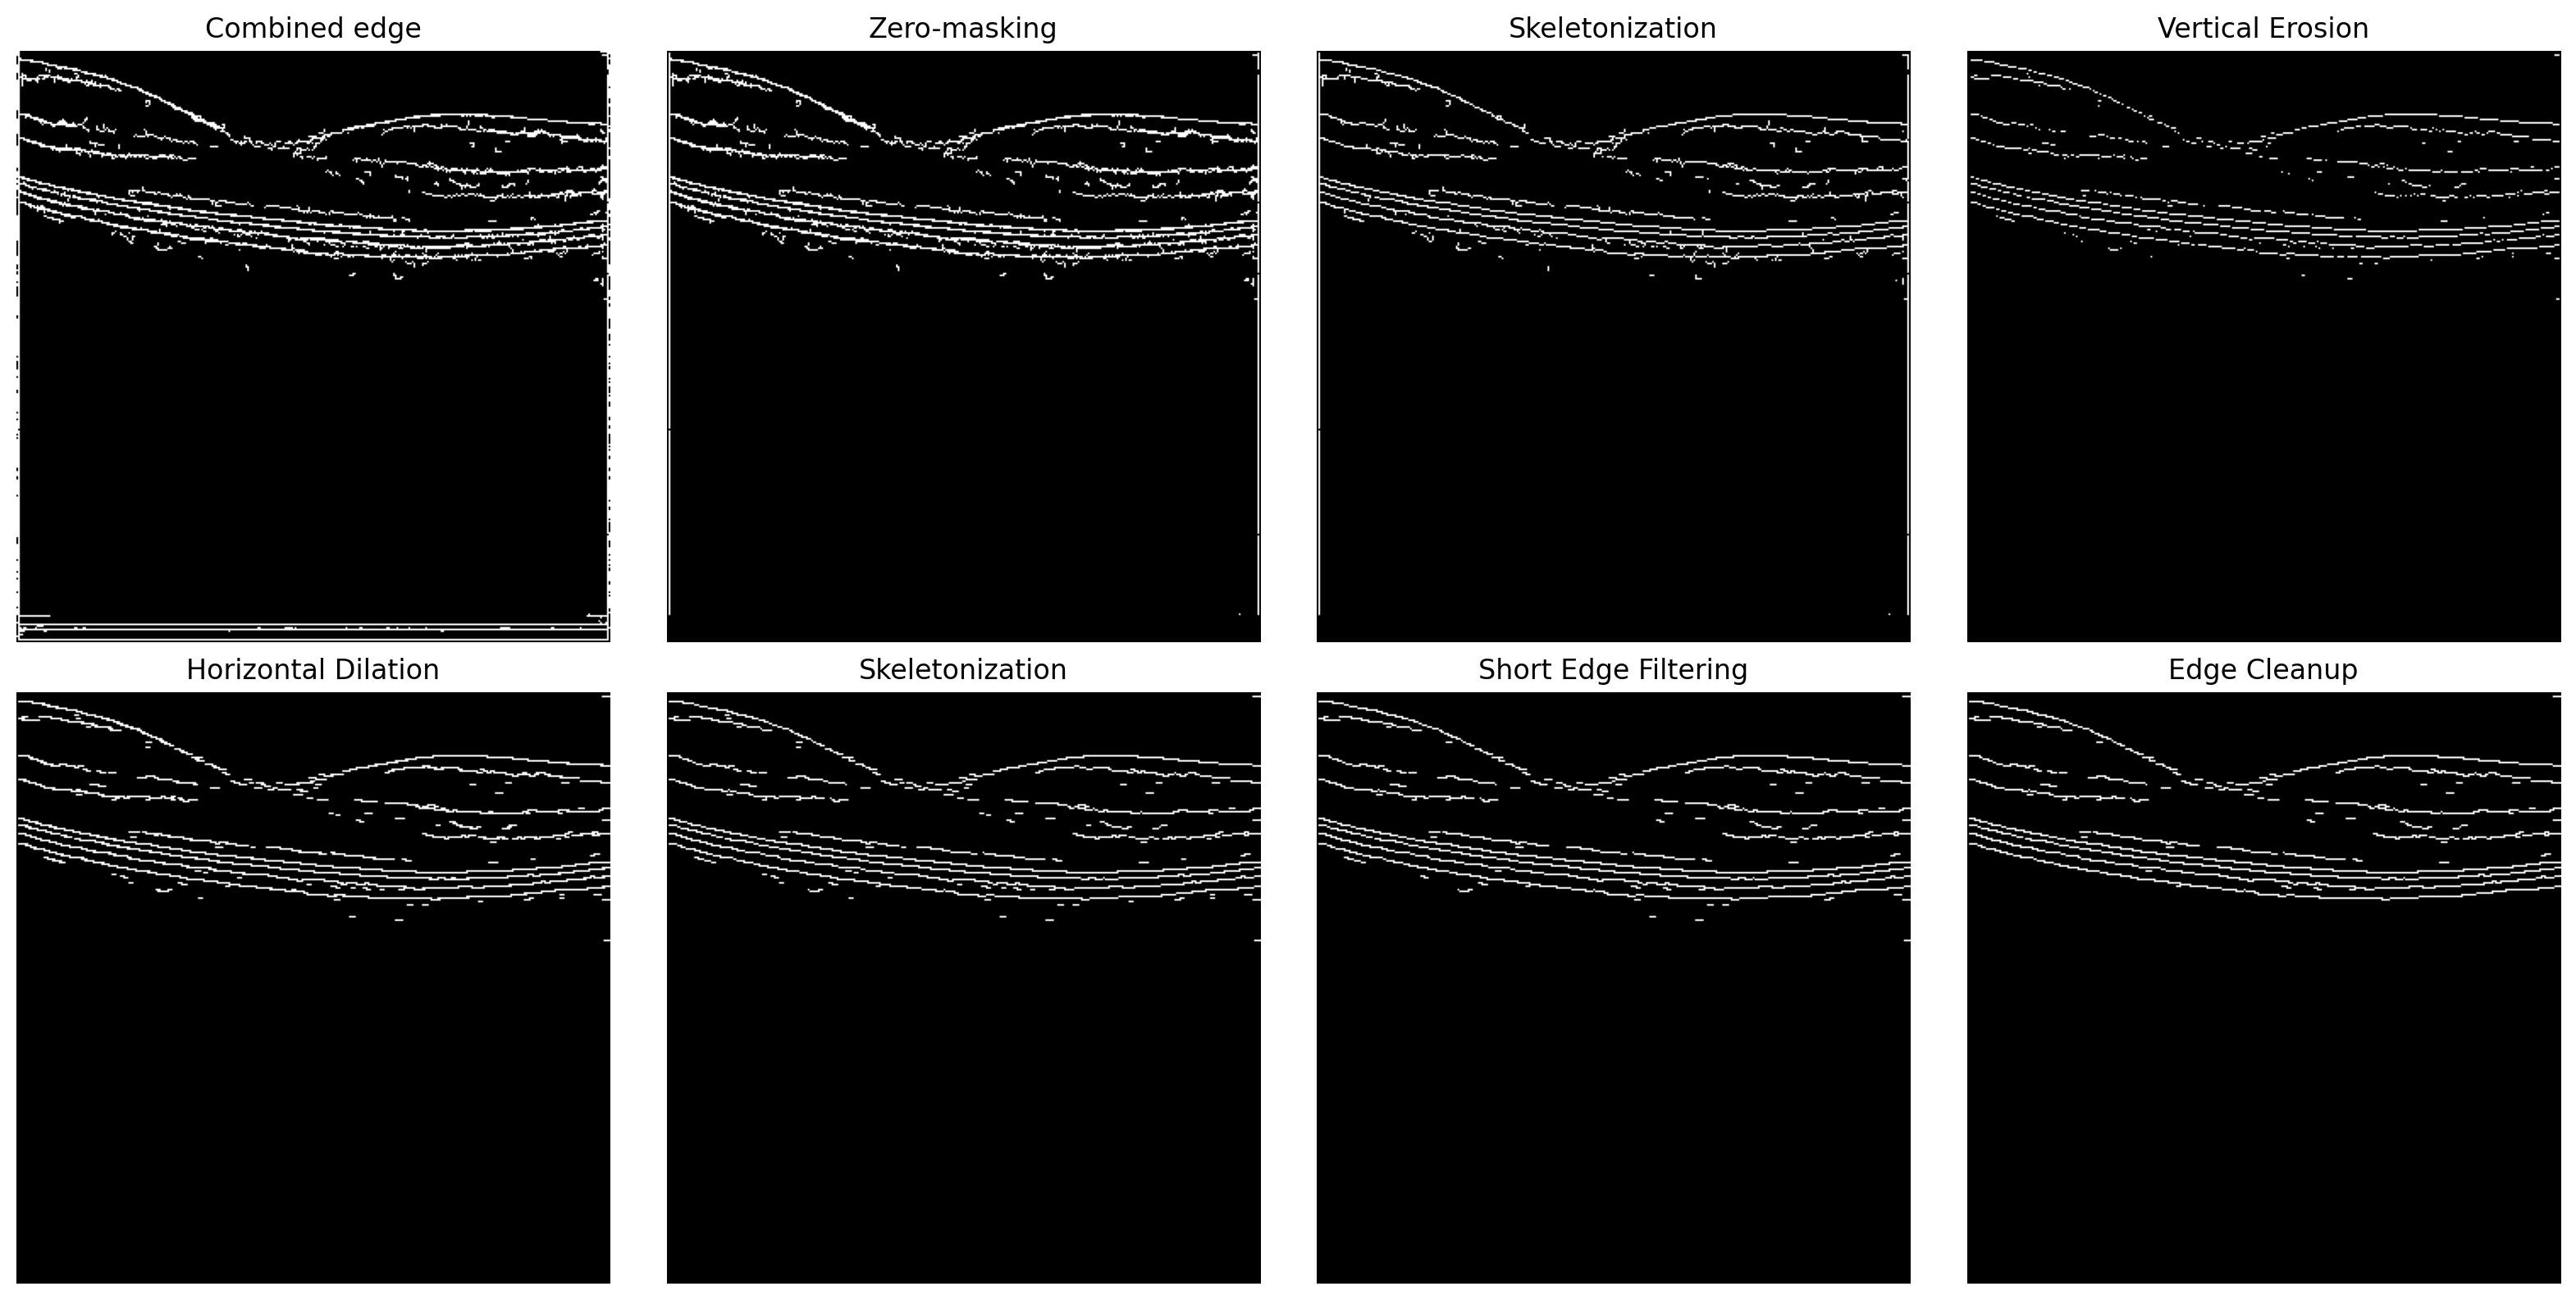

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8), facecolor='white', dpi=200)

plot_images = [edge, edge_zero, edge_skeleton1, edge_vert,
               edge_hori, edge_skeleton2, edge_final, edge_final2]
plot_titles = ['Combined edge', 'Zero-masking', 'Skeletonization', 'Vertical Erosion',
               'Horizontal Dilation', 'Skeletonization', 'Short Edge Filtering', 'Edge Cleanup']

for i in range(8):
    ax[i//4, i%4].imshow(plot_images[i], cmap='gray')
    ax[i//4, i%4].set_title(plot_titles[i])
    ax[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

### View the blended image

Edge result is superimposed onto the original image

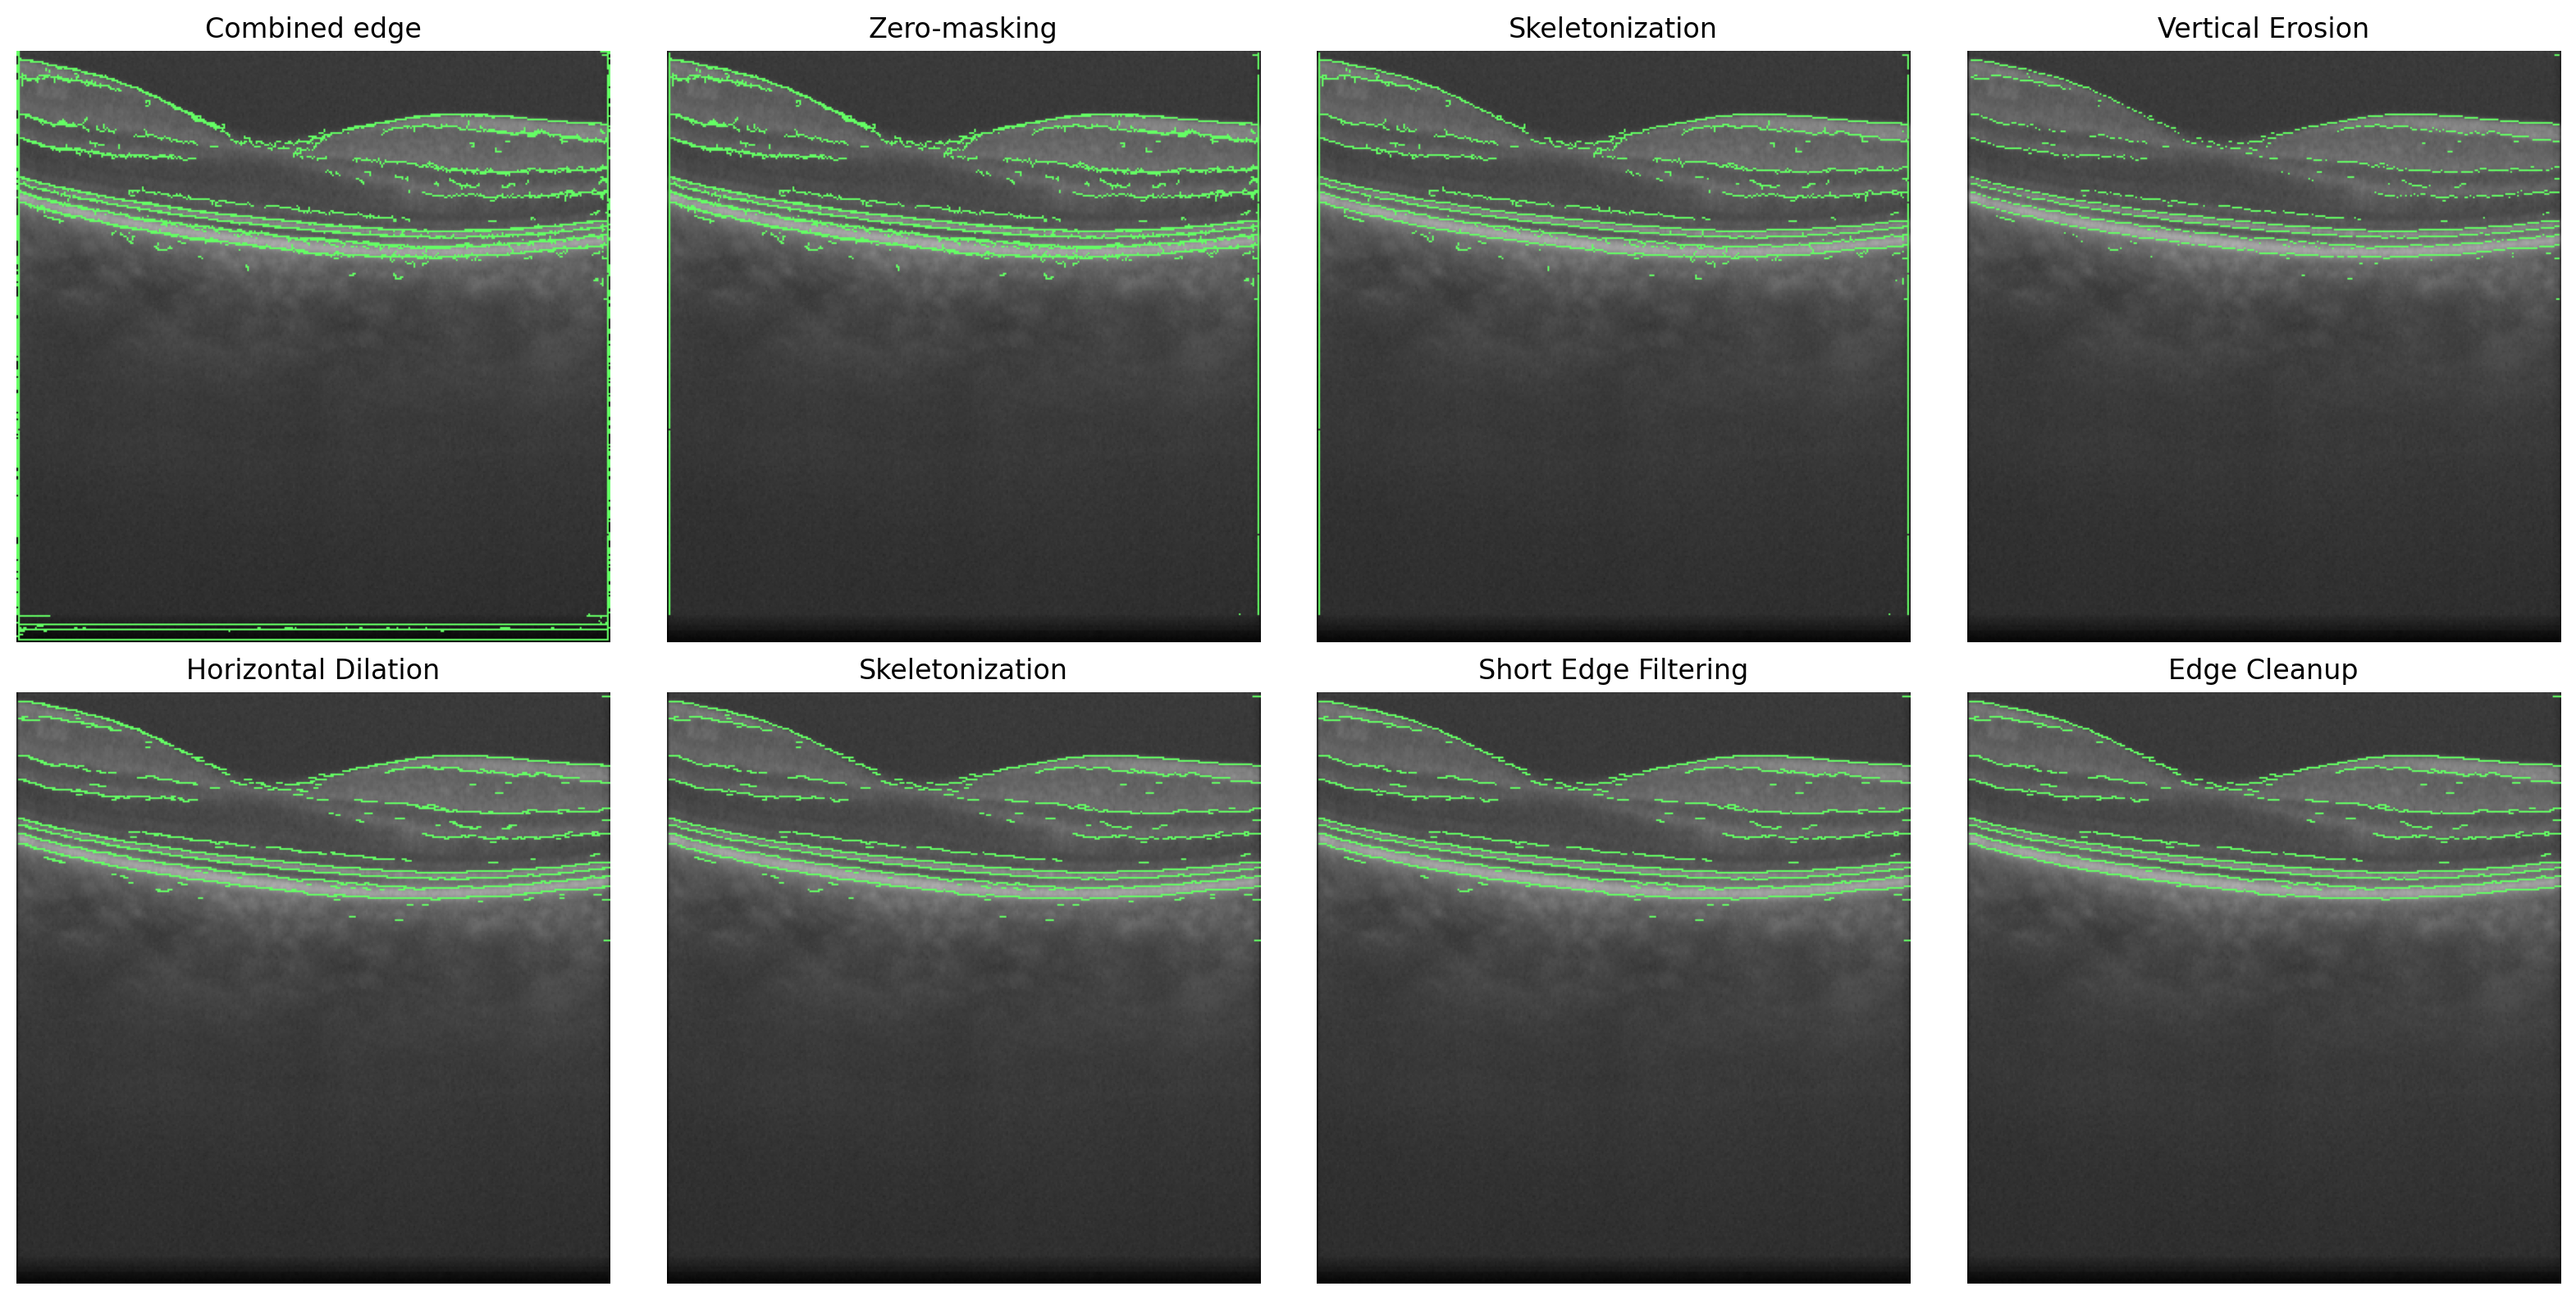

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8), facecolor='white', dpi=200)


plot_images = [edge, edge_zero, edge_skeleton1, edge_vert,
               edge_hori, edge_skeleton2, edge_final, edge_final2]
plot_titles = ['Combined edge', 'Zero-masking', 'Skeletonization', 'Vertical Erosion',
               'Horizontal Dilation', 'Skeletonization', 'Short Edge Filtering', 'Edge Cleanup']

for i in range(8):
    blended = np.repeat(np.expand_dims(tavg_images[0], -1), 3, axis=-1).astype(np.uint8)
    blended[np.where(plot_images[i] == 255)] = [100, 255, 100]
    ax[i//4, i%4].imshow(blended, cmap='gray')
    ax[i//4, i%4].set_title(plot_titles[i])
    ax[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

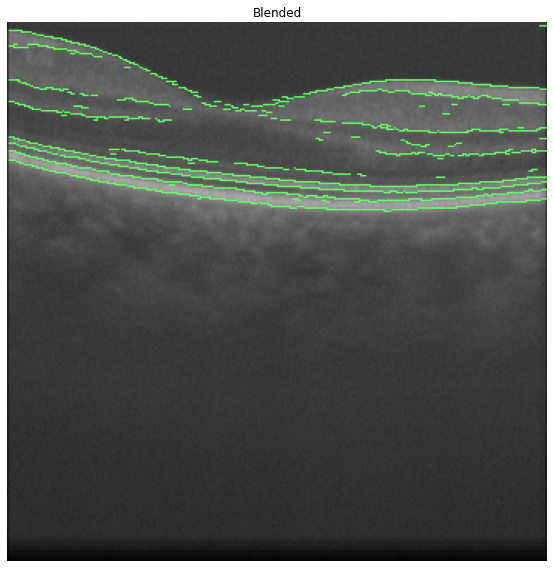

In [20]:
blended = np.repeat(np.expand_dims(tavg_images[0], -1), 3, axis=-1).astype(np.uint8)
blended[np.where(edge_final2 == 255)] = [100, 255, 100]

fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='white')
ax.imshow(blended)
ax.set_title('Blended')
ax.axis('off')

plt.tight_layout()
plt.show()

### EXTRA: Sharpening and smoothing

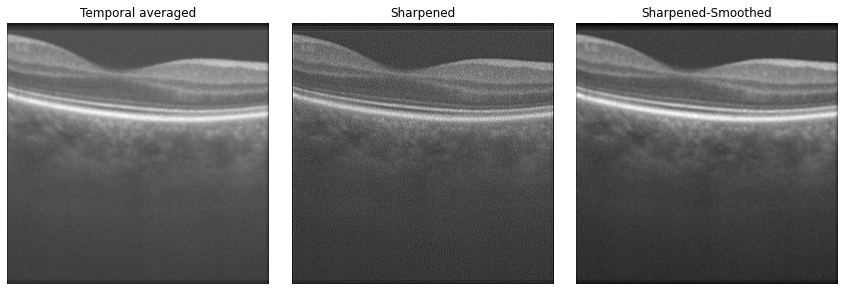

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(tavg_images[0], cmap='gray')
ax[0].set_title('Temporal averaged')
ax[0].axis('off')

sharpened = cv2.filter2D(tavg_images[0], -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
sharpened = np.clip(sharpened, 0, 255)
ax[1].imshow(sharpened, cmap='gray')
ax[1].set_title('Sharpened')
ax[1].axis('off')

smoothed = cv2.GaussianBlur(sharpened, (5, 5), 0)
ax[2].imshow(smoothed, cmap='gray')
ax[2].set_title('Sharpened-Smoothed')
ax[2].axis('off')

plt.tight_layout()
plt.show()

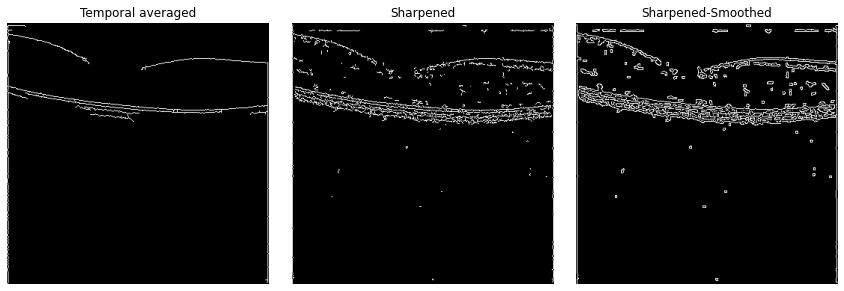

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
tavg = tavg_images[0]
tavg = cv2.Canny(tavg.astype(np.uint8), 50, 180)
ax[0].imshow(tavg, cmap='gray')
ax[0].set_title('Temporal averaged')
ax[0].axis('off')

sharpened = cv2.filter2D(tavg_images[0], -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
sharpened = np.clip(sharpened, 0, 255)
sharpened = cv2.Canny(sharpened.astype(np.uint8), 100, 180)
ax[1].imshow(sharpened, cmap='gray')
ax[1].set_title('Sharpened')
ax[1].axis('off')

smoothed = cv2.GaussianBlur(sharpened, (5, 5), 0)
smoothed = cv2.Canny(smoothed.astype(np.uint8), 100, 180)
ax[2].imshow(smoothed, cmap='gray')
ax[2].set_title('Sharpened-Smoothed')
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Temporal averaging

Experimental functions used earlier

In [12]:
def temporal_averaging(images, offset, n):
    assert offset+n < len(images)
    first_image = images[offset]
    corrected_images = []
    for i in range(offset, offset+n):
        offset_image = images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=100, overlap_ratio=0.9)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)
    tavg_image = np.mean(corrected_images, axis=0)
    return tavg_image

Nwindow = 30
averaged_images = []

with imageio.get_writer(f'viz_outputs/retina2_corrected_Nwindow_{Nwindow}.gif', mode='I', fps=30) as writer:
    for i in tqdm(range(len(images)-Nwindow), desc=f'Temporal averaging for Nwindow={Nwindow}'):
        tavg_image = temporal_averaging(images, i, Nwindow)
        averaged_images.append(tavg_image)
        image_copy = tavg_image.copy().astype(np.uint8)
        cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}:{i+Nwindow+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(image_copy, f'Image {i+FILENAME_OFFSET}:{i+Nwindow+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        writer.append_data(image_copy)

Temporal averaging for Nwindow=30: 100%|██████████| 199/199 [07:05<00:00,  2.14s/it]


In [19]:
Nwindow = 30
first_image = averaged_images[0]

with imageio.get_writer(f'viz_outputs/retina2_corrected_Nwindow_{Nwindow}.gif', mode='I', fps=10) as writer:

    for i in tqdm(range(len(averaged_images)), desc=f'Temporal averaging for Nwindow={Nwindow}'):
    
        offset_image = averaged_images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1)
        corrected_image = scipy.ndimage.shift(offset_image, shift).astype(np.uint8)

        cv2.putText(corrected_image, f'Image {i-Nwindow+FILENAME_OFFSET}-{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(corrected_image, f'Image {i-Nwindow+FILENAME_OFFSET}-{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)
        writer.append_data(corrected_image)

Temporal averaging for Nwindow=30: 100%|██████████| 199/199 [00:13<00:00, 14.46it/s]


In [14]:
for Nwindow in range(5, 60, 5)[:1]:
    
    first_image = scipy.ndimage.shift(images[0], (10, 0))
    corrected_images = [first_image]

    for i in range(Nwindow-1):
        offset_image = images[i]
        shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1, overlap_ratio=0.1)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)

    with imageio.get_writer(f'viz_outputs/retina2_corrected_Nwindow_{Nwindow}.gif', mode='I', fps=30) as writer:

        for i in tqdm(range(Nwindow, len(images)), desc=f'Temporal averaging for Nwindow={Nwindow}'):
            
            corrected_images.pop(0)
            offset_image = images[i]
            shift, error, diffphase = phase_cross_correlation(first_image, offset_image, upsample_factor=1)
            corrected_image = scipy.ndimage.shift(offset_image, shift)
            corrected_images.append(corrected_image)

            tavg_image = np.mean(corrected_images, axis=0).astype(np.uint8)
            cv2.putText(tavg_image, f'Image {i-Nwindow+FILENAME_OFFSET}:{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.putText(tavg_image, f'Image {i-Nwindow+FILENAME_OFFSET}:{i+FILENAME_OFFSET}', (10, H-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
            writer.append_data(tavg_image)

Temporal averaging for Nwindow=5: 100%|██████████| 224/224 [00:16<00:00, 13.32it/s]


In [22]:
cv2.imwrite('viz_outputs/sample_172_201_Nwindow30.bmp', averaged_images[0])

True